In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
model = lgb.Booster(model_file = "lightgbm_fraud_baseline.txt")

In [3]:
print(len(model.feature_name()))

430


In [4]:
importance_df = pd.DataFrame({
    "feature" : model.feature_name(),
    "importance": model.feature_importance(importance_type = "gain")
})

In [5]:
importance_df = importance_df.sort_values(
    by = "importance", ascending= False)

In [6]:
importance_df.head(20)

,feature,importance
308,V258,112734.717282
14,C1,45351.811713
27,C14,41905.301380
4,card2,31371.276279
3,card1,27216.414009
0,TransactionDT,26557.431941
26,C13,26480.506570
344,V294,25568.638129
29,D2,25151.629685
9,addr1,24298.245621


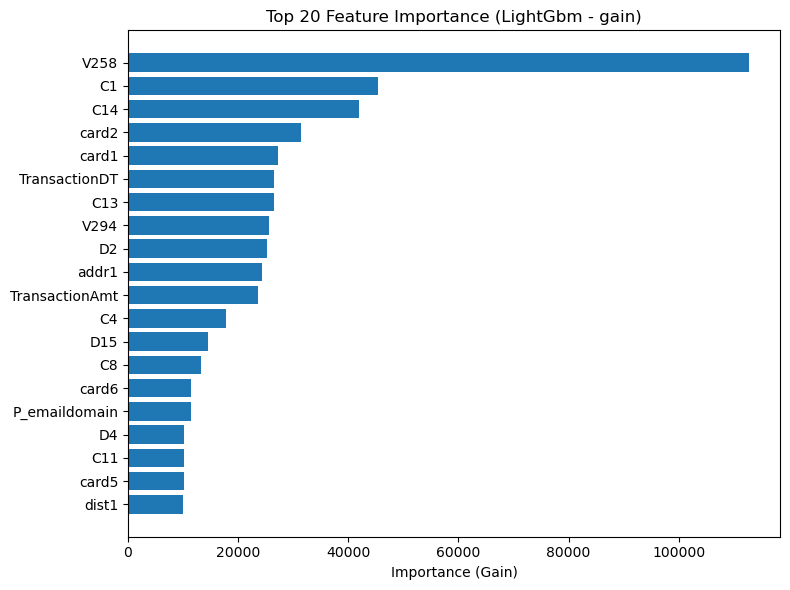

In [7]:
top_n = 20
plt.figure(figsize=(8,6))
plt.barh(
    importance_df["feature"].head(top_n)[::-1],
    importance_df["importance"].head(top_n)[::-1]
)
plt.title("Top 20 Feature Importance (LightGbm - gain)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

In [9]:
train_transaction = pd.read_csv(
    "train_transaction.csv",
    low_memory = False
)

In [10]:
for col in train_transaction.columns:
    if train_transaction[col].dtype == "float64":
        train_transaction[col] = train_transaction[col].astype("float32")
    elif train_transaction[col].dtype == "int64":
        train_transaction[col] = train_transaction[col].astype("int32")

In [11]:
missing_ratio = train_transaction.isna().mean()
drop_cols = missing_ratio[missing_ratio > 0.9].index

train_transaction.drop(drop_cols, axis = 1, inplace = True)

In [12]:
train_identity = pd.read_csv(
    "train_identity.csv",
    low_memory = False)

for col in train_identity.columns:
    if train_identity[col].dtype == "float64" :
        train_identity[col] = train_identity[col].astype("float32")

In [13]:
train_df = train_transaction.merge(
    train_identity,
    on = "TransactionID",
    how = "left")

In [14]:
import gc

In [15]:
del train_transaction, train_identity
gc.collect()

0

In [16]:
train_df = train_df.sort_values("TransactionDT")

split_ratio = 0.8
split_index = int(len(train_df) * split_ratio)

train_data = train_df.iloc[:split_index]
val_data = train_df.iloc[split_index:]

X_train = train_data.drop(columns=["isFraud" , "TransactionID"])
y_train = train_data["isFraud"]

X_val = val_data.drop(columns = ["isFraud" , "TransactionID"])
y_val = val_data["isFraud"]

print("Train shape :" , X_train.shape)
print("Validation shape :", X_val.shape)

print("Fraud rate in trian :" , y_train.mean())
print("Fraud rate in validation :" , y_val.mean())

Train shape : (472432, 430)
Validation shape : (118108, 430)
Fraud rate in trian : 0.03513521522674162
Fraud rate in validation : 0.034409184813899145


In [17]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight

27.46147358274595

In [18]:
from sklearn.preprocessing import LabelEncoder

In [20]:
cat_cols = X_train.select_dtypes(include = "object").columns
print(len(cat_cols))
print(cat_cols)

31
Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')


In [21]:
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()

    X_train[col] = le.fit_transform(X_train[col].astype(str))

    X_val[col] = X_val[col].astype(str)

    unseen = set(X_val[col]) - set(le.classes_)
    if unseen:
        le.classes_ = np.append(le.classes_, list(unseen))

    X_val[col] = le.transform(X_val[col])

    label_encoders[col] = le

In [22]:
del train_df
del train_data
del val_data
del cat_cols
del label_encoders
import gc
gc.collect()

145

In [23]:
params = {
    "objective" : "binary",
    "metric" : "acu",
    "booting_type" : "gbdt",

    "learning_rate" :0.05,
    "num_leaves" : 64,
    "max_depth" : -1,

    "feture_fraction" : 0.8,
    "bagging_fraction" : 0.8,
    "bagging_freq" : 5,

    "min_data_in_leaf" : 50,
    "verbosity" : -1,
    "seed" :42}

In [24]:
import lightgbm as lgb

lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val,
    label=y_val,
    reference=lgb_train,
    free_raw_data=False
)


In [25]:
params_imbalance = params.copy()
params_imbalance["scale_pos_weight"] = scale_pos_weight

In [27]:
params_imbalance["metric"] = "auc"

In [28]:
model_imbalance = lgb.train(
    params_imbalance,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_val],
    valid_names=["valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.898177
[100]	valid's auc: 0.907721
[150]	valid's auc: 0.911469
[200]	valid's auc: 0.914407
[250]	valid's auc: 0.915747
[300]	valid's auc: 0.914987
Early stopping, best iteration is:
[250]	valid's auc: 0.915747


In [29]:
y_val_proba = model.predict(X_val)

In [30]:
threshold = 0.5

In [31]:
y_val_pred = (y_val_proba >= threshold).astype(int)

In [32]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

accuracy  = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall    = recall_score(y_val, y_val_pred)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)

Accuracy : 0.9752006637992346
Precision: 0.7853192559074912
Recall   : 0.3843503937007874


In [33]:
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[113617,    427],
       [  2502,   1562]], dtype=int64)

In [34]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.79      0.38      0.52      4064

    accuracy                           0.98    118108
   macro avg       0.88      0.69      0.75    118108
weighted avg       0.97      0.98      0.97    118108



In [35]:
y_val_proba = model.predict(X_val)

In [36]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

results = []

for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)
    
    results.append({
        "threshold": t,
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred)
    })

results_df = pd.DataFrame(results)
results_df

,threshold,accuracy,precision,recall
0,0.5,0.975201,0.785319,0.384350
1,0.4,0.974625,0.725011,0.422982
2,0.3,0.972737,0.644323,0.463583
3,0.2,0.968410,0.542163,0.526821
4,0.1,0.951705,0.379695,0.636811


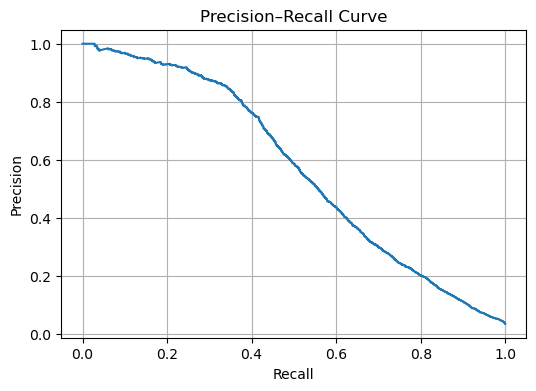

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix

chosen_threshold = 0.3
y_final_pred = (y_val_proba >= chosen_threshold).astype(int)

confusion_matrix(y_val, y_final_pred)

array([[113004,   1040],
       [  2180,   1884]], dtype=int64)

In [39]:
print(confusion_matrix(y_val, y_final_pred))
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)

[[113004   1040]
 [  2180   1884]]
Accuracy : 0.9752006637992346
Precision: [0.03440918 0.03440948 0.03440977 ... 1.         1.         1.        ]
Recall   : [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 4.92125984e-04
 2.46062992e-04 0.00000000e+00]
